In [1]:
# data process
import pandas as pd

# plot functions
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# text process
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# LDA model
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
from gensim.corpora import Dictionary

# visualization LDA model
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import math

### Load Dataset

In [3]:
df_reddit = pd.read_csv("/Users/yhu245/Documents/GitHub/breast_cancer_analysis/q4_tw_rd/data/data_reddit_processed.csv")

In [4]:
df_reddit.head()

,user_id,timestamp,text
0,incredally07,1602699352,I just need to complain a little. I got my la...
1,cookiebatter123,1602637885,My mum (50) has just been diagnosed with tripl...
2,wonkishgardener,1602630055,3 days of radiation left (woo hoo!) and sudden...
3,HonorableMention111,1602628724,I’ve been on chemo since the beginning of June...
4,Handy_Raccoon323,1602627408,Please excuse the formatting I'm on shitty mob...


### Preprocess the Text

Here we only consider bags of word presentation of text and could also try Bigrams and Trigrams model.

In [15]:
stemmer = PorterStemmer()
def clean_tweets(df=df_reddit, tweet_col='text', date_col='timestamp'):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words
    en_stop_words = set(stopwords.words('english'))
    en_stop_words = en_stop_words | \
                        {
                            'breast', 'cancer', 'b', 'breastcancer'                        
                        }
    url_re = re.compile('http')
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in en_stop_words) and (not re.search(url_re, word)) ]))
    
    # tokenize the tweets
    #tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    tokenizer = RegexpTokenizer(r"\w+")
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    x_re = '^[x][a-zA-Z0-9_]*'
    df_copy['tokenized_' + tweet_col] = df_copy['tokenized_' + tweet_col].apply(lambda row: [stemmer.stem(word) for word in row if (not word in en_stop_words) and (not re.match(x_re, word)) ])


    
    return df_copy
  
df_reddit_clean = clean_tweets()
df_reddit_clean.head()

,user_id,timestamp,text,preprocessed_text,tokenized_text
0,incredally07,1602699352,I just need to complain a little. I got my la...,need complain little. got last tissue expander...,"[need, complain, littl, got, last, tissu, expa..."
1,cookiebatter123,1602637885,My mum (50) has just been diagnosed with tripl...,mum (50) diagnosed triple negative cancer. doc...,"[mum, 50, diagnos, tripl, neg, doctor, say, ch..."
2,wonkishgardener,1602630055,3 days of radiation left (woo hoo!) and sudden...,"3 days radiation left (woo hoo!) suddenly, lik...","[3, day, radiat, left, woo, hoo, suddenli, lik..."
3,HonorableMention111,1602628724,I’ve been on chemo since the beginning of June...,i’ve chemo since beginning june final dose tom...,"[chemo, sinc, begin, june, final, dose, tomorr..."
4,Handy_Raccoon323,1602627408,Please excuse the formatting I'm on shitty mob...,please excuse formatting i'm shitty mobile. (m...,"[pleas, excus, format, shitti, mobil, hubbi, d..."


### Train LDA model

In [9]:
# the dictionary would create a dictionary and assign an unique id for each word
reddit_dictionary = Dictionary(df_reddit_clean.tokenized_text) 

# build the corpus i.e. vectors with the number of occurence of each word per tweet
reddit_corpus = [reddit_dictionary.doc2bow(reddit) for reddit in df_reddit_clean.tokenized_text] # corpus would record the number of occurance of each word per tweet but save as a sparse format to save space

Here we tune the number of the topics using all the trainning data. It would be better that we split the dataset into train and test then decide the number of topics based on the coherence score in test data. Based on the coherence score, 3 would be a good choice.

In [11]:
%%time
reddit_coherence = []
for nb_topics in range(3, 10):
    lda = LdaMulticore(reddit_corpus, num_topics = nb_topics, id2word = reddit_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=reddit_corpus, dictionary = reddit_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    reddit_coherence.append(coh)

CPU times: user 54 s, sys: 9.69 s, total: 1min 3s
Wall time: 1min 40s


Text(0, 0.5, 'Coherance Score')

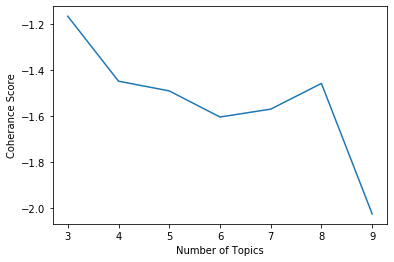

In [12]:
plt.figure()
plt.plot(range(3, 10), reddit_coherence)
plt.xlabel('Number of Topics')
plt.ylabel('Coherance Score')

CPU times: user 20 s, sys: 96.8 ms, total: 20.1 s
Wall time: 14.4 s


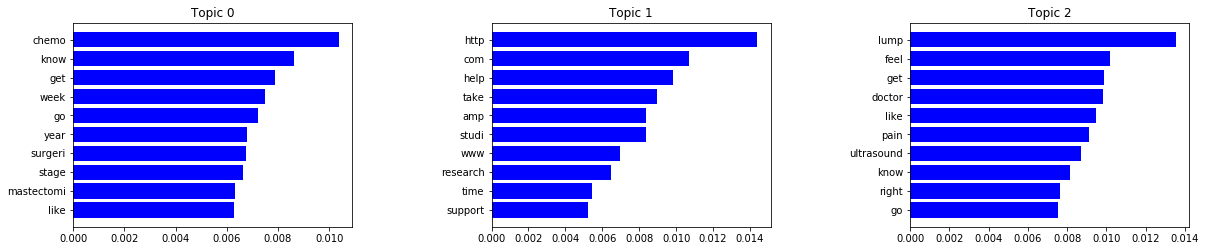

In [16]:
%%time
k = 3
reddit_lda = LdaModel(reddit_corpus, num_topics = k, id2word = reddit_dictionary, passes=10)
def plot_top_words(lda=reddit_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(reddit_lda, reddit_corpus, reddit_dictionary)
LDAvis_prepared

/Users/yhu245/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.054190 -0.084278       1        1  43.906059
2     -0.122193  0.065083       2        1  40.134941
1      0.176383  0.019195       3        1  15.958999, topic_info=     Category         Freq        Term        Total  loglift  logprob
399   Default  1027.000000        lump  1027.000000  30.0000  30.0000
678   Default   427.000000        http   427.000000  29.0000  29.0000
861   Default   318.000000         com   318.000000  28.0000  28.0000
55    Default   854.000000       chemo   854.000000  27.0000  27.0000
270   Default   664.000000  ultrasound   664.000000  26.0000  26.0000
882   Default   297.000000       studi   297.000000  25.0000  25.0000
812   Default   372.000000         amp   372.000000  24.0000  24.0000
16    Default   865.000000        help   865.000000  23.0000  23.0000
805   Default   208.000000         www   208.000000  22.0000  22.0000
261   Default   806.000000        take   806.000000  21.0000  21.0000
794   Default   552.000000   mammogram   552.000000  20.0000  20.0000
381   Default   592.000000   treatment   592.000000  19.0000  19.0000
459   Default   277.000000    research   277.000000  18.0000  18.0000
637   Default   353.000000       notic   353.000000  17.0000  17.0000
71    Default   573.000000     surgeri   573.000000  16.0000  16.0000
1172  Default   475.000000       nippl   475.000000  15.0000  15.0000
292   Default   539.000000  mastectomi   539.000000  14.0000  14.0000
89    Default   394.000000      radiat   394.000000  13.0000  13.0000
883   Default   153.000000      survey   153.000000  12.0000  12.0000
116   Default   615.000000       stage   615.000000  11.0000  11.0000
31    Default   872.000000        pain   872.000000  10.0000  10.0000
982   Default   268.000000       women   268.000000   9.0000   9.0000
305   Default   325.000000     support   325.000000   8.0000   8.0000
368   Default   293.000000  oncologist   293.000000   7.0000   7.0000
85    Default   598.000000        left   598.000000   6.0000   6.0000
874   Default   139.000000        link   139.000000   5.0000   5.0000
887   Default   192.000000     univers   192.000000   4.0000   4.0000
183   Default   793.000000       right   793.000000   3.0000   3.0000
500   Default   242.000000      inform   242.000000   2.0000   2.0000
181   Default   266.000000       pleas   266.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2474   Topic3    31.829954     student    33.678551   1.7787  -6.8246
812    Topic3   245.638168         amp   372.101379   1.4198  -4.7811
459    Topic3   189.470276    research   277.864624   1.4522  -5.0408
337    Topic3    53.817303   psycholog    63.232590   1.6739  -6.2994
741    Topic3    60.637024    survivor    77.033073   1.5958  -6.1801
982    Topic3   147.821381       women   268.192047   1.2394  -5.2890
887    Topic3   109.843819     univers   192.013245   1.2766  -5.5859
500    Topic3   126.393448      inform   242.542480   1.1834  -5.4456
305    Topic3   152.701294     support   325.626617   1.0779  -5.2565
16     Topic3   287.926056        help   865.972168   0.7340  -4.6223
181    Topic3   127.982224       pleas   266.170166   1.1029  -5.4331
261    Topic3   262.738037        take   806.002625   0.7142  -4.7138
552    Topic3   110.822914     complet   249.143036   1.0251  -5.5771
567    Topic3   138.272339       peopl   376.834106   0.8326  -5.3558
46     Topic3   125.201271         use   341.161835   0.8327  -5.4551
562    Topic3   115.837212        life   335.055603   0.7730  -5.5328
293    Topic3    84.253662     patient   181.652039   1.0669  -5.8512
356    Topic3    92.958778     current   233.321075   0.9149  -5.7528
42     Topic3   149.842667       thank   772.407532   0.1952  -5.2754
194    Topic3   158.550949        time  1011.478516  -0.0179  -5.2189
607    Topic3    86.721786        risk   208.40